### Importing Libraries
Here, we are importing libraries that will be used for monumentum factor stock selection & risk parity portfolio construction, risk portfolio analysis, time management, threading, and backtesting with the Zipline Reloaded framework.

In [2]:
import pandas as pd
import numpy as np

import riskfolio as rp
import pyfolio as pf

from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (
    symbol,
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    get_datetime,
    set_commission,
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    schedule_function,
    set_commission,
    set_slippage,
    set_benchmark
)
from zipline.finance import commission, slippage
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
import warnings
warnings.filterwarnings("ignore")

### Trade settings
Instead of hard coding these settings inside the backtest, we'll make it easier on ourselves by setting them up front. In this case, set the number of long  positions to take in our portfolio and the average dollar volume screener.
For the portfolio construction we set the maximum number of stocks to include, the methods, the minimum return and the bar count.

In [3]:
# TRADE SETTINGS
N_LONGS = 50
DOLLAR_VOLUME = 500

# SETTINGS FOR RISK PARITY
max_n_assets = 10 # set the maximum number of assets because of the low portfolio value

bar_count = 66
method_mu = "hist"
method_cov = "hist"
lower_ret = 0.0008

### The custom momentum factor
The class inherits from CustomFactor and specifies its inputs and the window length required for its computations. The inputs include the closing price of US equities (USEquityPricing.close) and the returns over a specified window length (126 trading days in this case). The window_length attribute is set to 252, which typically represents the number of trading days in a year. The compute method is where the core logic of the factor is implemented. This method is automatically called by Zipline with the necessary data aligned according to the specified inputs and window_length. The compute method calculates the momentum factor for each asset based on price changes over different periods: the change in price over the last 252 days (1 year) and the change over the last 21 days (1 month). This is then normalized by the standard deviation of returns over the specified period, to account for volatility. This normalization provides a relative measure of momentum, making it more comparable across different assets.

In [4]:
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]
            - (prices[-1] - prices[-21]) / prices[-21]
        ) / np.nanstd(returns, axis=0)

### Create the Pipeline
A Pipeline is a framework that allows for the definition and efficient computation of a wide array of financial data over a set of assets. Within this pipeline, it incorporates a custom factor, MomentumFactor(), and a built-in factor, AverageDollarVolume(window_length=30). The pipeline is set up with four columns: "factor" holds the computed momentum values, "longs" and "shorts" represent the top and bottom assets based on momentum for a specified number of assets (N_LONGS and N_SHORTS), and "ranking" provides a rank of assets based on their momentum. We then use the built in AverageDollarVolume factor to set a screener to only include the top 500 assets by dollar volume.

In [5]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=21)
    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(N_LONGS),
            "ranking": momentum.rank()
        },
        screen=dollar_volume.top(DOLLAR_VOLUME),
    )

### Recalculate the momentum factor
This function will be called before the trading day starts. It recalculate the factor values for each asset in the universe.

In [6]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")

### Initialize the backtest
The initialize function is run at the inception of the backtest. This is where we set up variables and execute calculations we want to use throughout the backtest. The context object is used to store state throughout the backtest. Here, we attach, or install, the Pipeline for use in the backtest. Then we schedule the rebalance function defined next to run at the market open every week on Monday. Finally, we set a commission and slippage model.

In [7]:
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )
    
    # Set up the commission model to charge us per share and a volume slippage model
    set_commission(
        us_equities=commission.PerShare(
            cost=0.005,
            min_trade_cost=2.0
        )
    )
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(
            volume_limit=0.0025, 
            price_impact=0.01
        )
    )

### Set our rebalance logic
In the initialize function, we scheduled the rebalance function to run. This is where the trade logic lives. First, we get DataFrame containing the factor data set in the before_trading_start function. We get the list of selected assets to trade the determine which assets to go long.
These assets are put into a portfolio and weights are calculated using risk parity portfolio construction.
Then we run the exec_trades function on each list passing in the appropriate weights.

In [8]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, "price"))

    longs = assets[factor_data.longs]
    filtered_factor_data = factor_data[factor_data['longs'] == True]
    top_longs = factor_data[factor_data['longs'] == True].nsmallest(max_n_assets, 'factor')
    
    # PORTFOLIO CONSTRUCTION & RISK PARITY
    prices = data.history(
        top_longs.index,  # Vervang 'assets' door 'top_longs.index'
        "price", 
        bar_count=bar_count, 
        frequency="1d"
    )

    returns = prices.pct_change()[1:]
    returns.dropna(how="any", axis=1, inplace=True)
    returns = returns.loc[:, (returns != 0).any(axis=0)]

    port = rp.Portfolio(returns=returns)
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
    port.lowerret = lower_ret

    weights = port.rp_optimization(
        model="Classic", 
        rm="MV", 
        hist=True, 
        rf=0.05, 
        b=None
    )
    
    print(f"{get_datetime().date()} {context.portfolio.portfolio_value}")
    
    if weights is not None:
        exec_trades(data, assets=assets, weights=weights)

### Execute the trades
We loop through every asset, determine if it's tradeable, the asset is weighted, and there are no open orders. Then we order the target percent and Zipline rebalances our portfolio for us.
This code comes from the risk parity portfolio notebook.

In [9]:
def exec_trades(data, assets, weights):
    # Loop through every asset...
    for asset in assets:
        # ...if the asset is tradeable and there are no open orders...
        if data.can_trade(asset) and asset in weights.index and not get_open_orders(asset):
            # ...execute the order against the target percent
            target_percent = weights.at[asset, "weights"]
            order_target_percent(asset, target_percent)

### Analyze the results
We can ask Zipline to run a function at the conclusion of the backtest. In this case, we simply print the equity curve.

In [10]:
def analyze(context, perf):
    perf.portfolio_value.plot()

### Run the backtest
Before we run the backtest we determine the settings for the period of the backtest, the bundle to use and the capital base. We also get the data for the benchmark.

Then the run_algorithm funtion kicks off the backtest. It takes the start and end date, the initialize function that runs at the inception of the backtest, the analyze function that runs at the conclusion of the backtest, the capital to start the backtest with, and the name of the bundle.

In [11]:
start = pd.Timestamp("2016-01-01")
end = pd.Timestamp("2017-12-31")
bundle="quandl"
capital_base=10_000

import pandas_datareader.data as web
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

2016-01-04 10000.0
2016-01-11 9706.329999994074
2016-01-19 9460.259999993013
2016-01-25 9384.409999987976
2016-02-01 9590.759999983748
The problem doesn't have a solution with actual input parameters
2016-02-08 7773.989999945732
2016-02-16 8620.399999945728
2016-02-22 8983.219999916524
2016-02-29 8983.849999915541
2016-03-07 9179.829999912381
2016-03-14 9510.219999779938
2016-03-21 9761.809999583167
2016-03-28 10109.719999580297
2016-04-04 10400.159999579966
2016-04-11 10177.049999573414
2016-04-18 10259.569999537562
2016-04-25 9598.129999534882
2016-05-02 10106.329999534802
2016-05-09 10554.499999534
2016-05-16 10682.069999532709
2016-05-23 9721.979999532621
2016-05-31 10319.949999524782
2016-06-06 10331.689999524548
2016-06-13 9979.109999522138
2016-06-20 10386.839999518357
2016-06-27 9489.79999949826
2016-07-05 11814.589999460753
2016-07-11 12664.399999444577
2016-07-18 12684.739999444195
2016-07-25 12980.499999438594
2016-08-01 12659.979999436764
2016-08-08 12026.959999423962
2016-

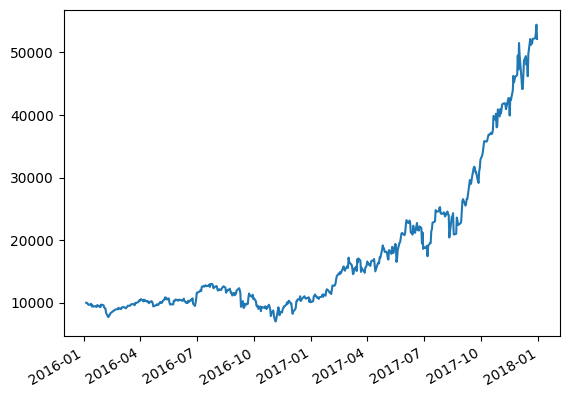

In [12]:
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    before_trading_start=before_trading_start,
    capital_base=capital_base,
    bundle=bundle,
    benchmark_returns=benchmark_returns
)


This performance chart is showing a enormous growth in portfolio value in 2017.
Is the code correct?
Even though SPY perfomed pretty good over the course of 2017 (from $227.21 to $266.86), the return is nowwhere near what the backtest is showing.

### Cache the performance output
Since `perf` is a DataFrame, we can use the pandas `to_pickle` method to serialize the performance output.

In [13]:
perf.to_pickle("momentum_rp_v1.pickle")

Then later, we can read it...

In [14]:
perf = pd.read_pickle("momentum_rp_v1.pickle")

### Prepare the performance DataFrame for PyFolio
Use the extract_rets_pos_txn_from_zipline utility method to extract the returns, positions, and transactions from the performance output of Zipline. 

In [15]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

### Framework 1: Return based statistics.
Risk and performance metrics that are generated by the periodic, portfolio-level percentage returns of a strategy.

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

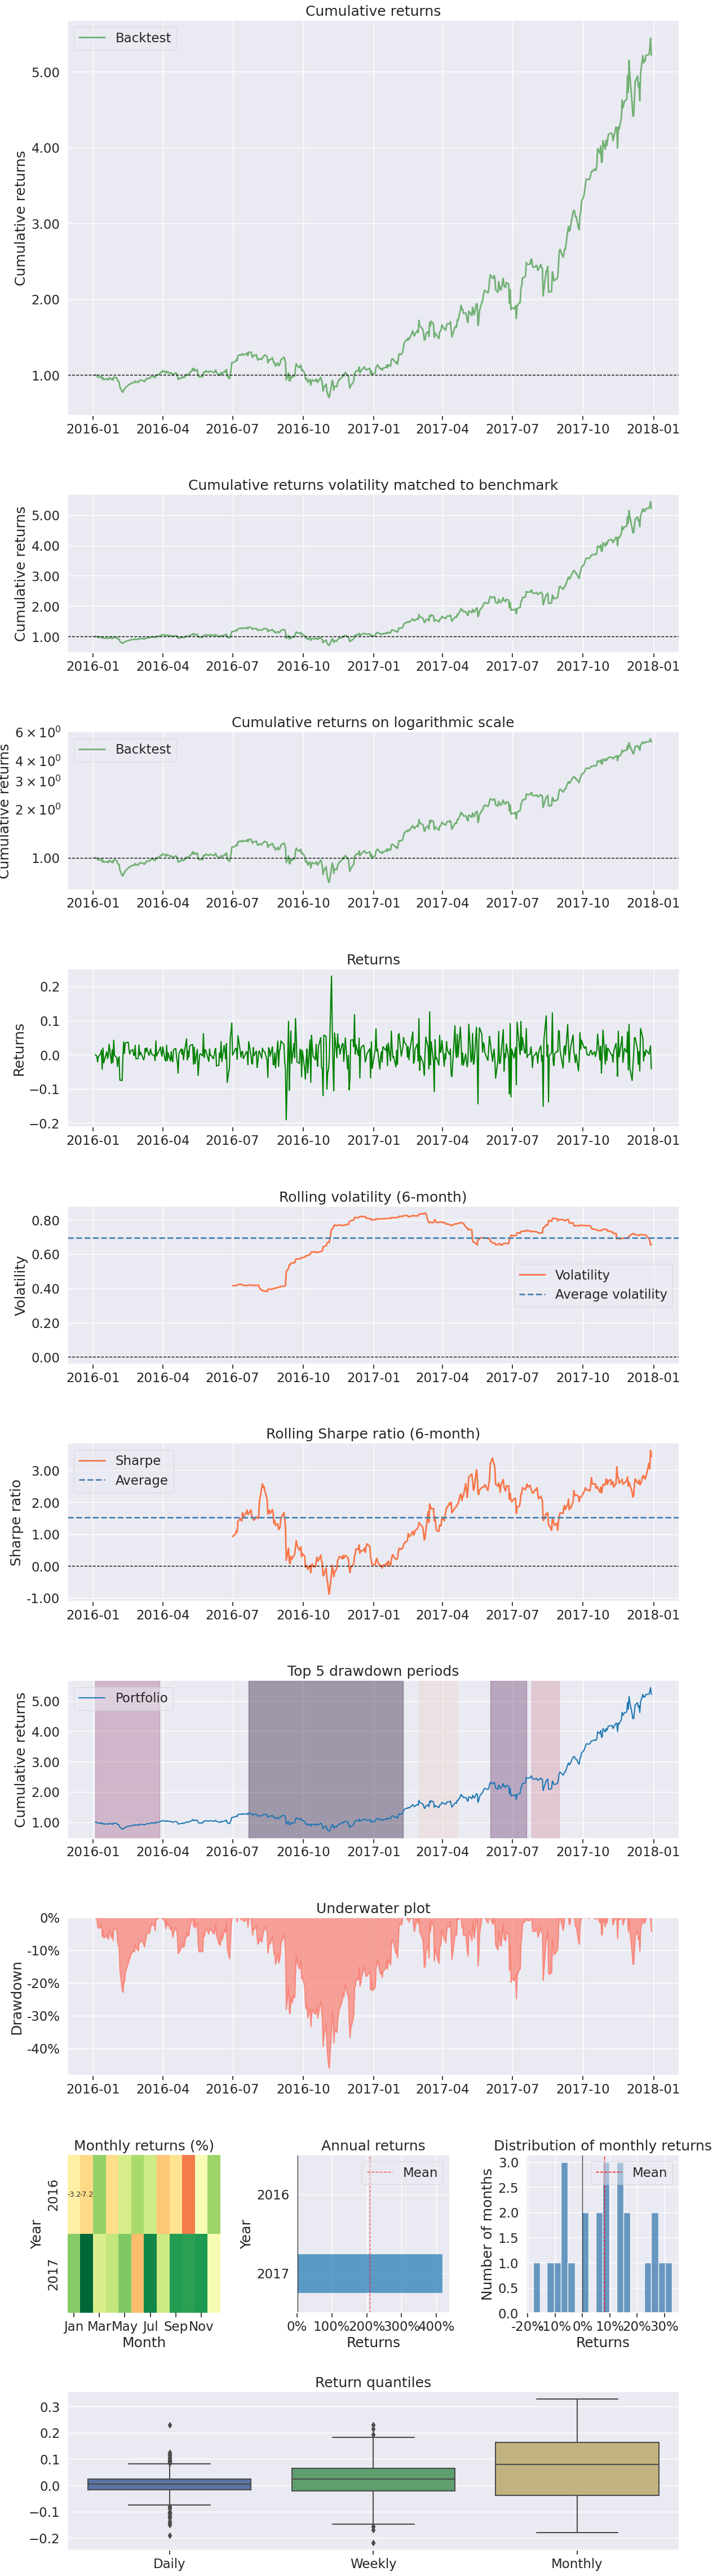

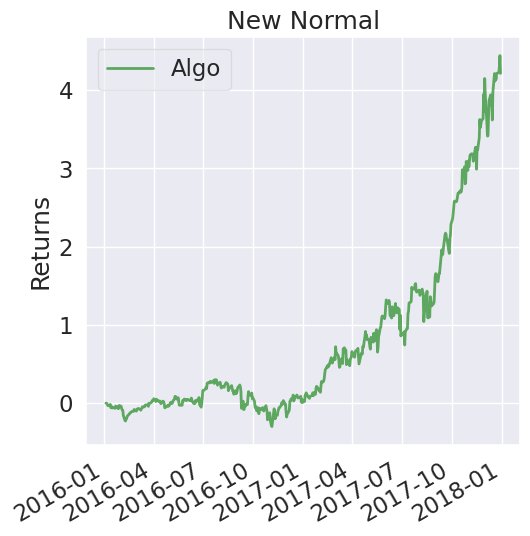

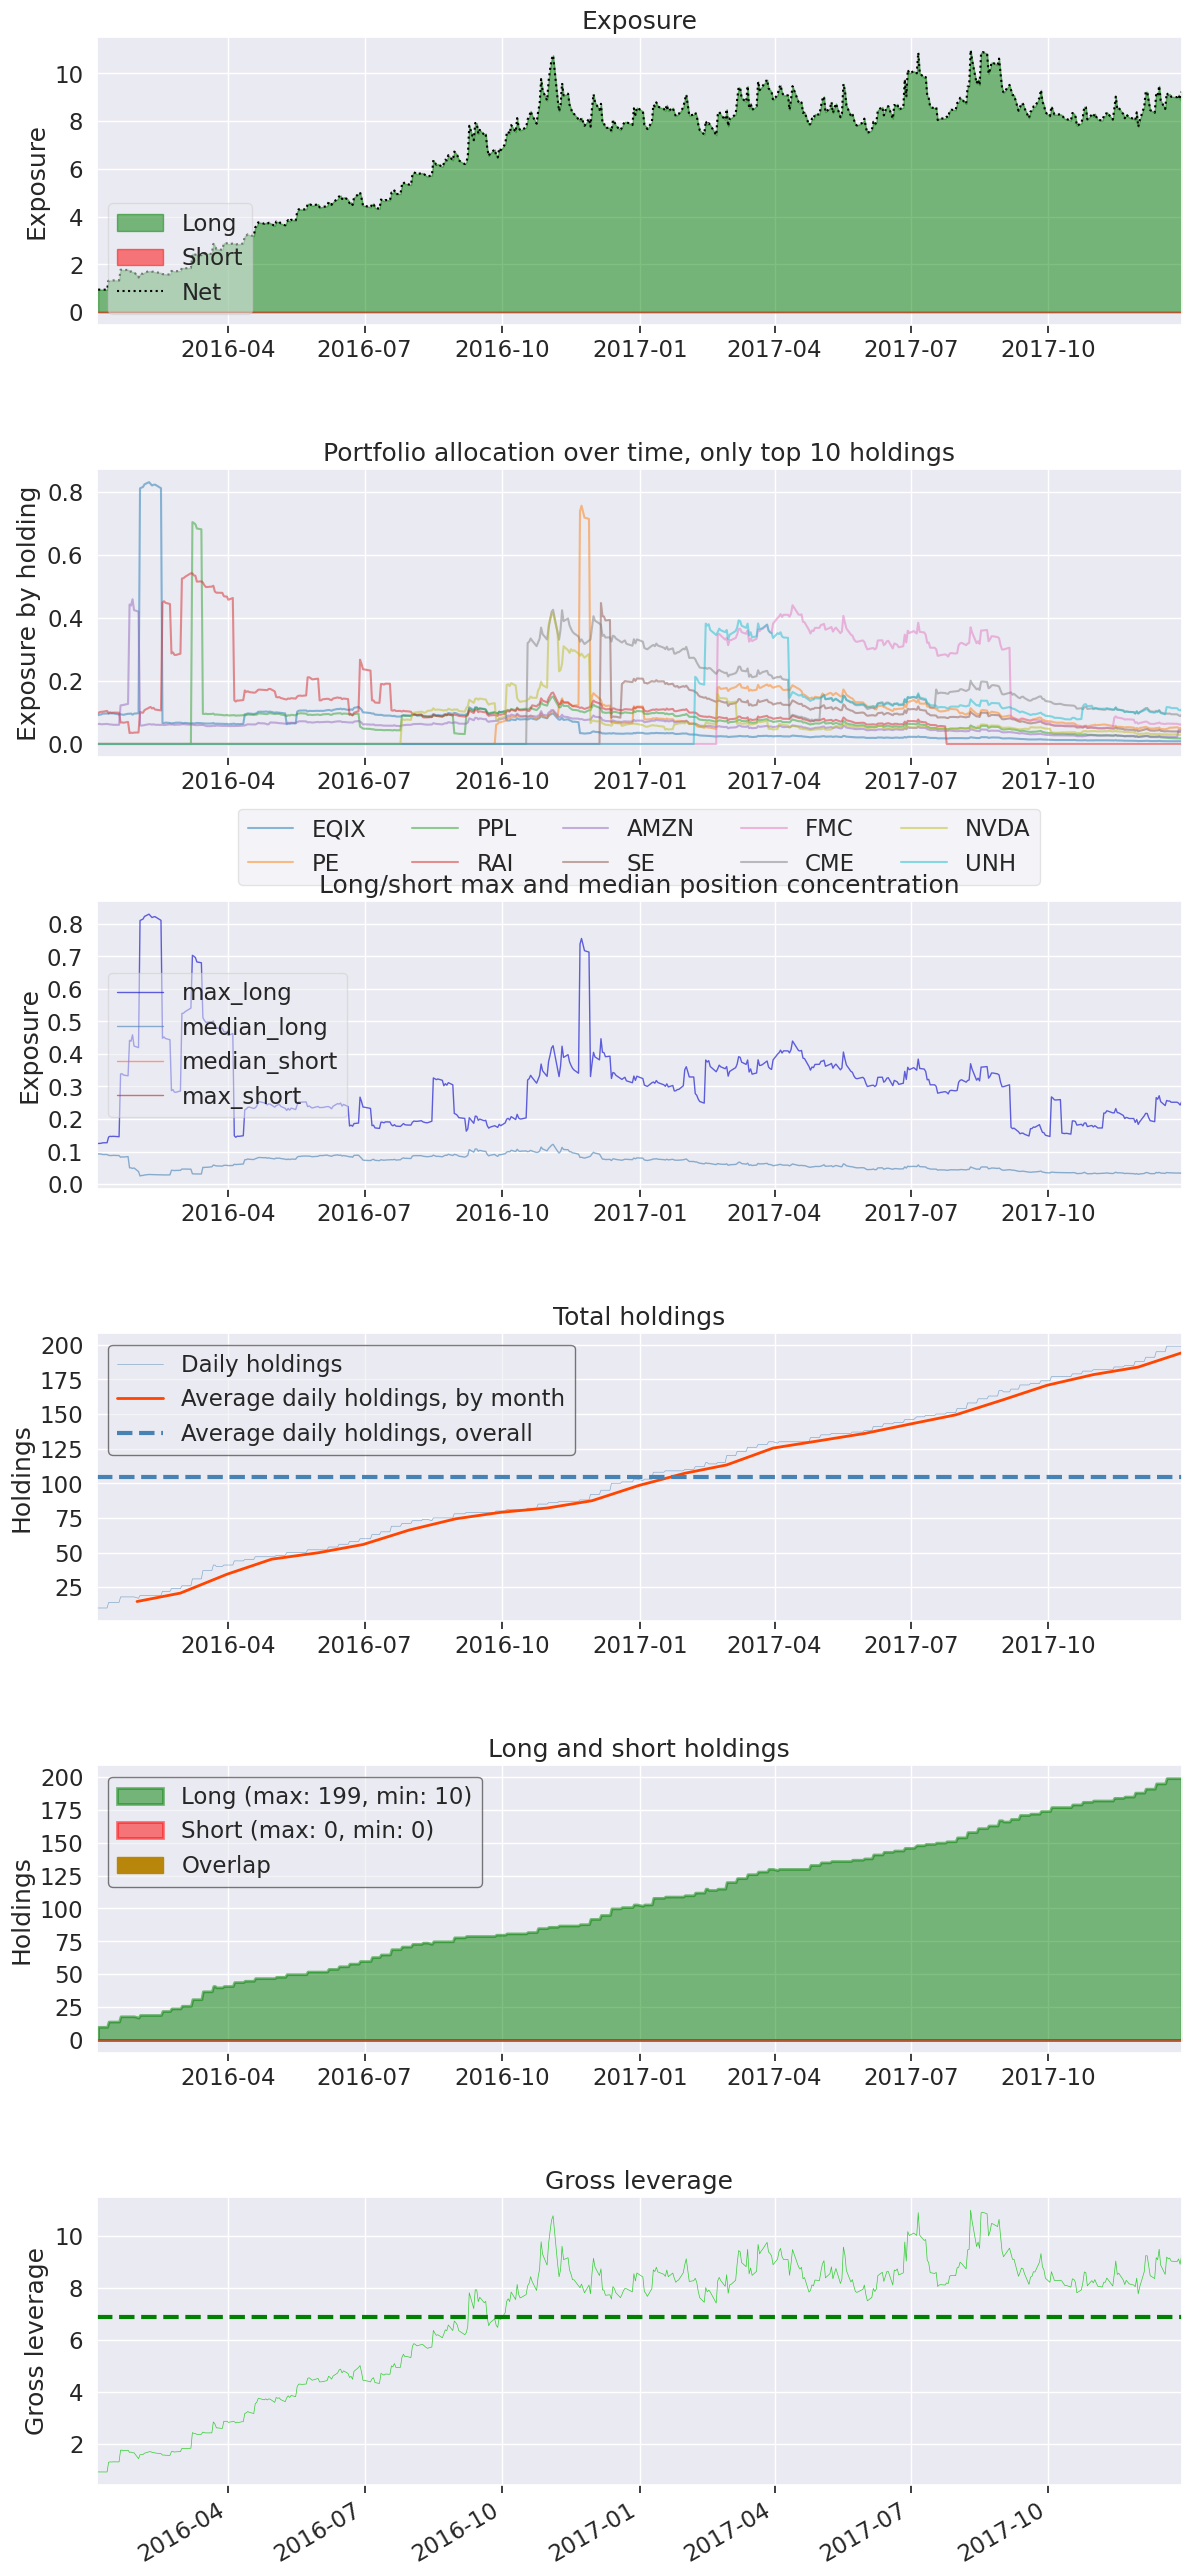

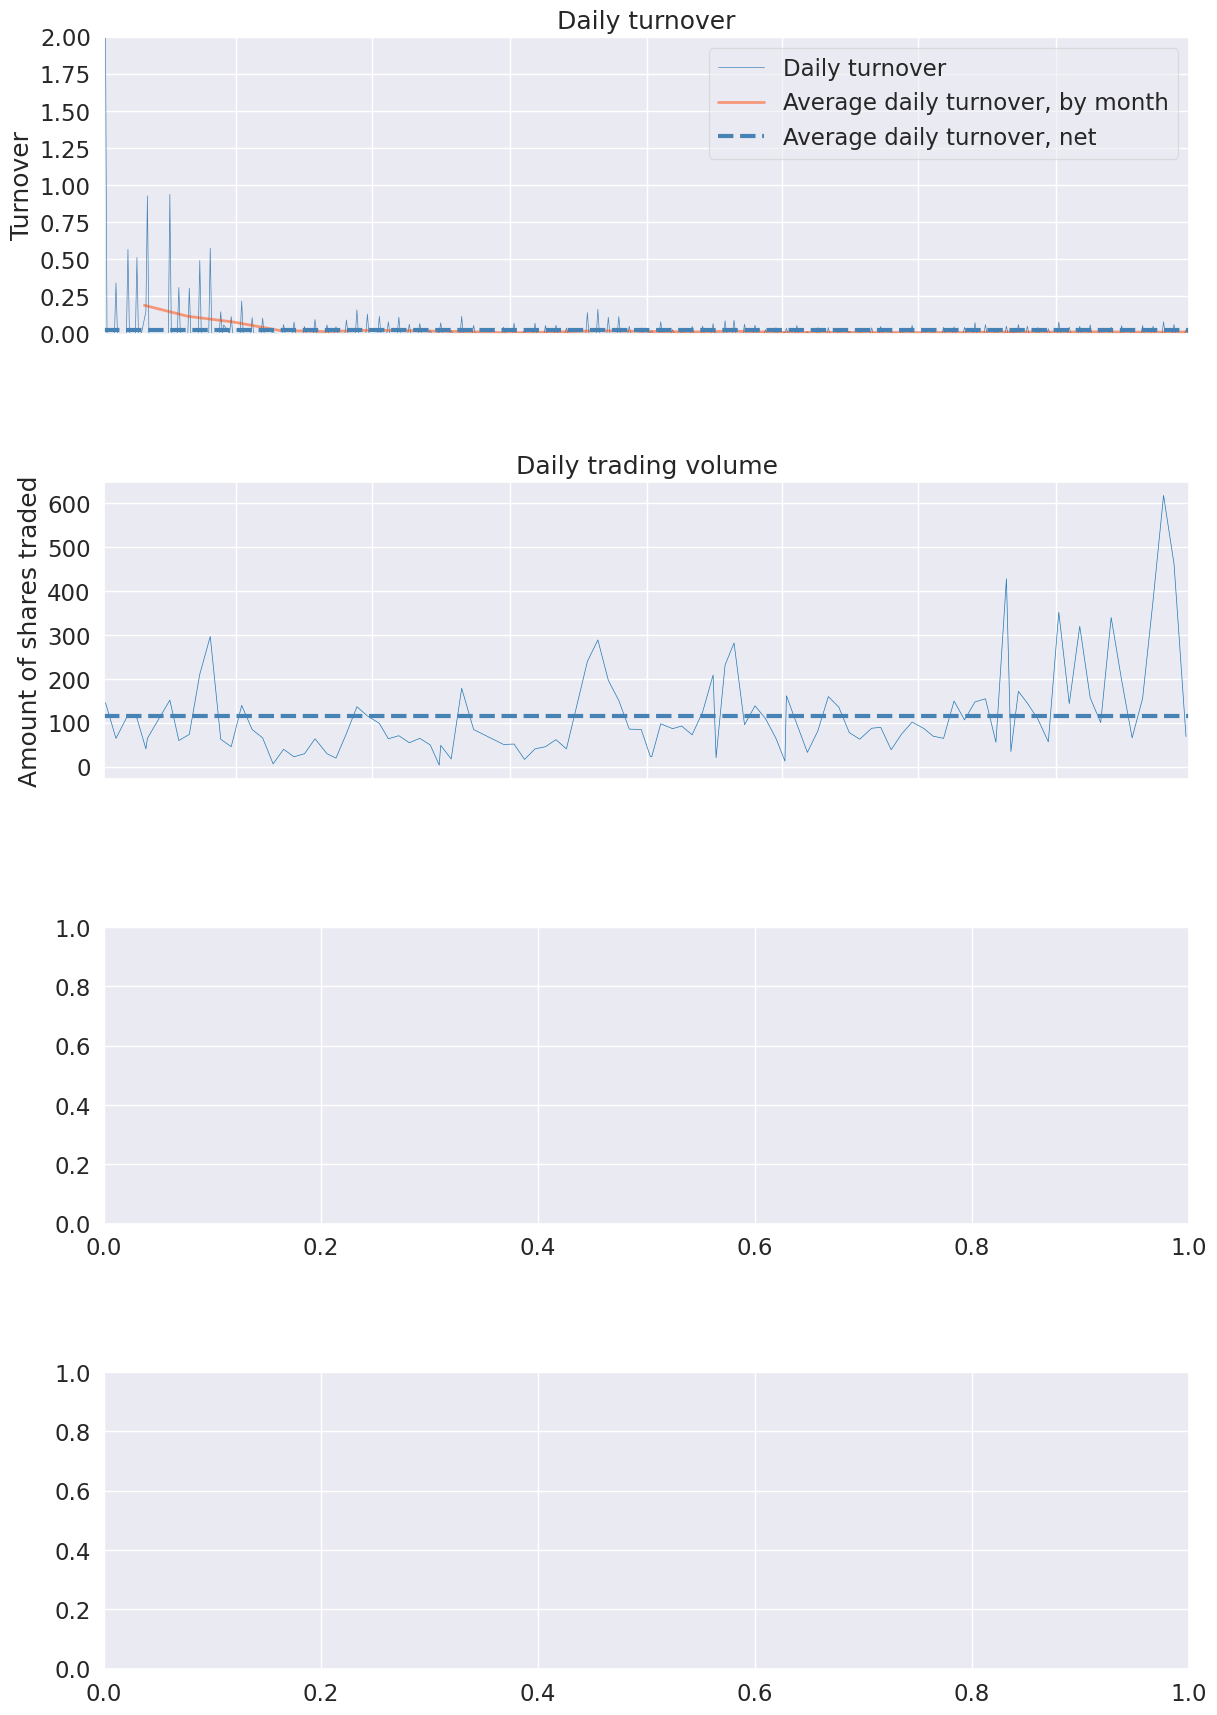

In [17]:
pf.create_full_tear_sheet(returns, positions, transactions)

### Framework 2: Transactions based
Risk and performance metrics that are generated by the individual trades within the strategy.

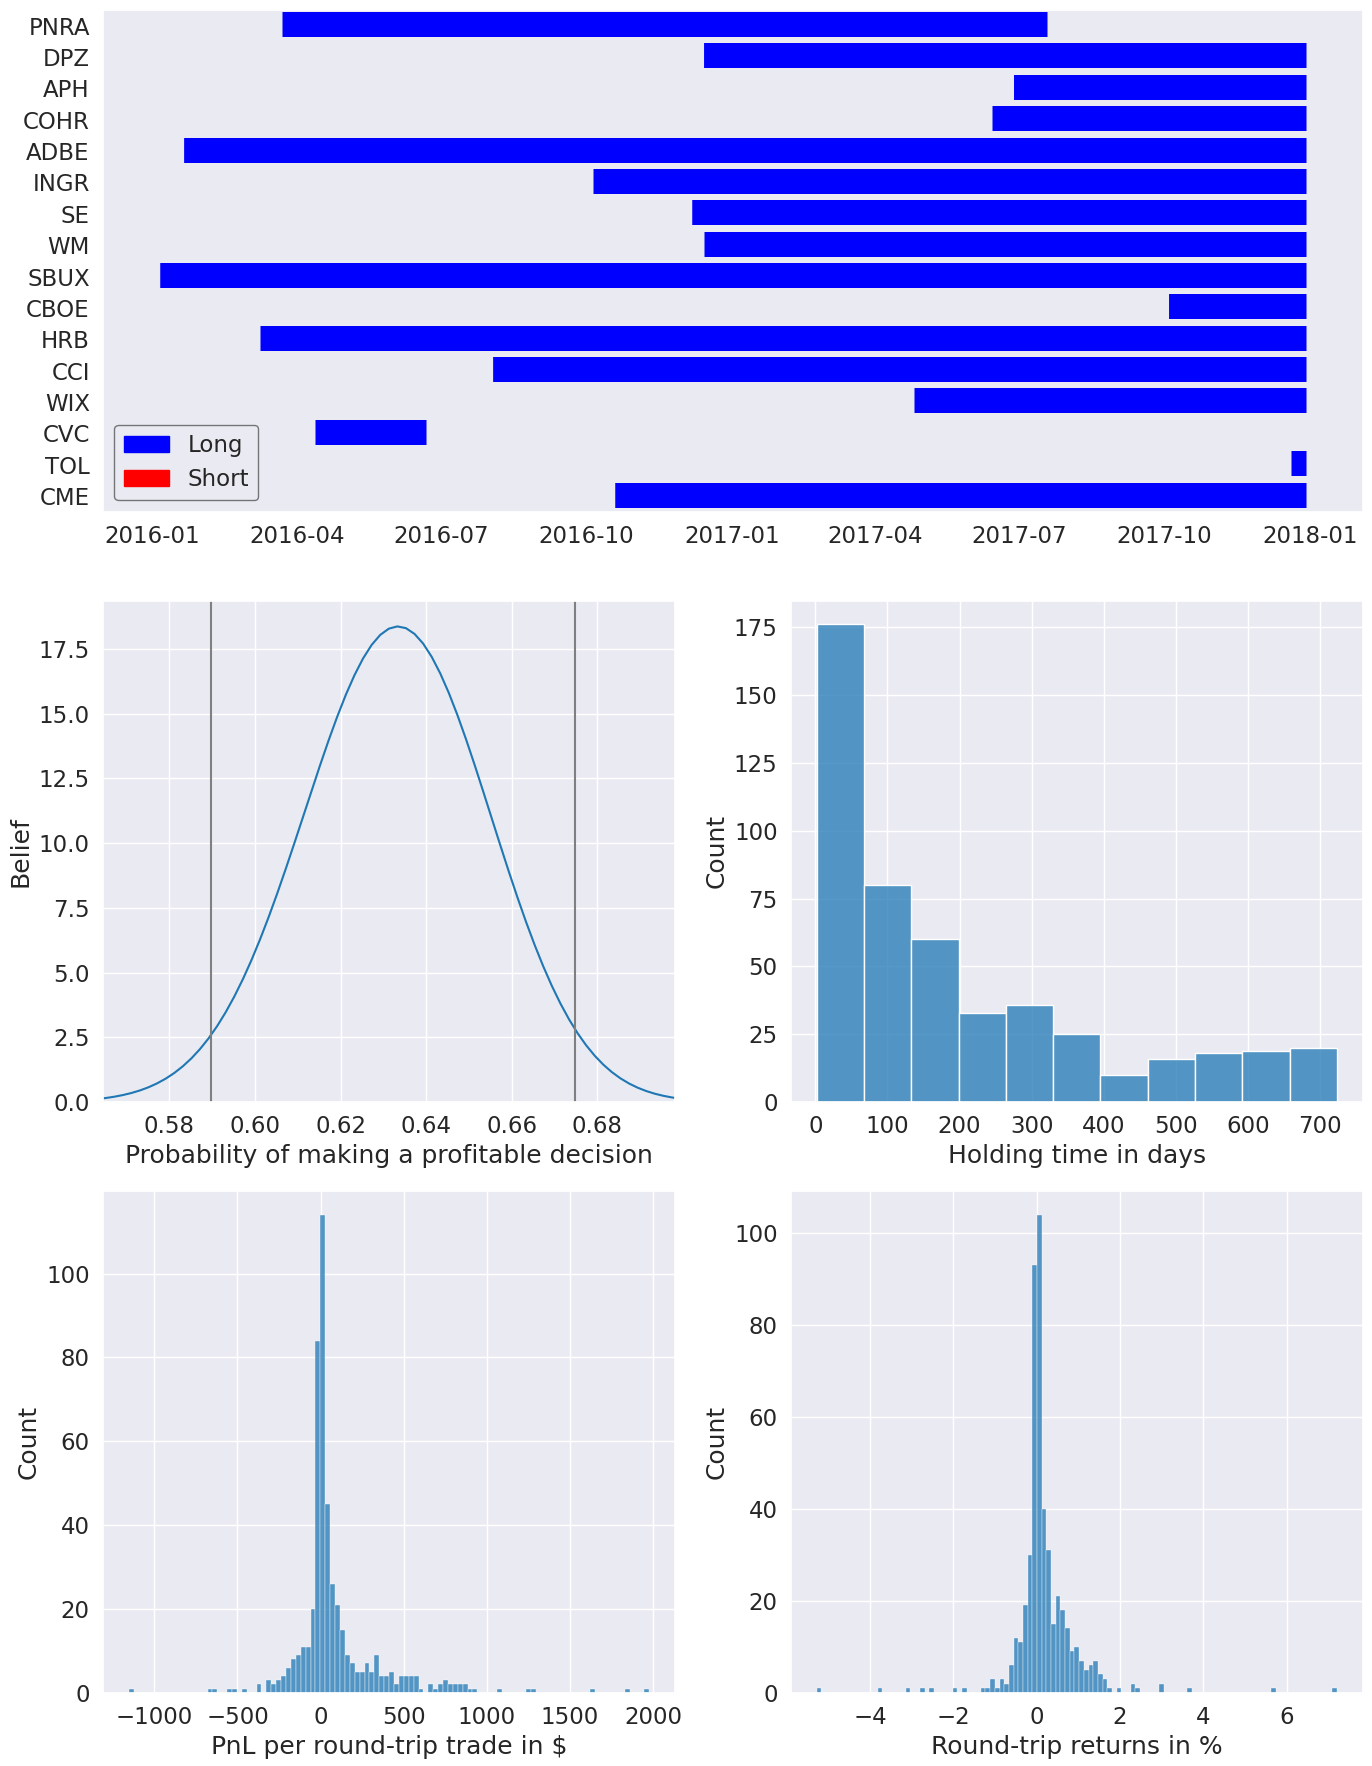

In [34]:
pf.create_round_trip_tear_sheet(returns, positions, transactions)

### Prepare the DataFrames for Alphalens
We need to do some basic pandas manipulation of the performance DataFrame to extract the historic prices and factor data from our backtest. Construct a DataFrame called prices where each column represents a symbol and each row represents a date. We do this by iterating through each row of prices using the items method which returns an iterator. Each key is the date and each value is a DataFrame representing price data. Each of these DataFrames is converted to a column with the date as the column's name using the to_frame method. The concat function then concatenates these columns horizontally using the axis=1 argument.

In [35]:
prices = pd.concat(
    [df.to_frame(d) for d, df in perf.prices.dropna().items()], 
    axis=1
).T
prices.columns = [col.symbol for col in prices.columns]
prices.index = prices.index.normalize()

To extract the factor data from the backtest output, we follow similar steps. First we iterate through factor_data column dropping any null values, and reshaping the data so that each date corresponds to a unique column. Next, we convert the column names to strings and adjust the dates like before. Finally, the DataFrame is transformed from a two-dimensional table into a one-dimensional series with a hierarchical index. We do this with the stack method, resulting in a multi-indexed Series where the primary level of the index is the date and the secondary level is the symbol. For clarity, these levels are named "date" and "asset."

In [36]:
factor_data = pd.concat(
    [df.to_frame(d) for d, df in perf.factor_data.dropna().items()], axis=1
).T
factor_data.columns = [col.symbol for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ["date", "asset"]

In [37]:
factor_data

date                       asset
2016-01-04 00:00:00+00:00  A        1092.0
                           AAL       969.0
                           AAP      1537.0
                           AAPL     1929.0
                           ABBV      718.0
                                     ...  
2017-12-29 00:00:00+00:00  NKTR     2312.0
                           BGC       397.0
                           FHN       542.0
                           ODFL     1909.0
                           DISCK      43.0
Length: 248968, dtype: float64

### Compute forward returns and quantiles
Now that the DataFrames are prepared, we can call the AlphaLens get_clean_factor_and_forward_returns function. The purpose of this function is to associate factor values with future returns. The output, stored in the variable alphalens_data, is a DataFrame that combines the factor data with the subsequent returns based on the provided prices. This merged structure allows us to analyze how specific factor values might have influenced or related to future asset returns.

In [38]:
alphalens_data = get_clean_factor_and_forward_returns(
    factor=factor_data, 
    prices=prices, 
    periods=(5, 10, 21, 63), 
    quantiles=5
)

Dropped 12.5% entries from factor data: 12.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


The resulting DataFrame has a MultiIndex with dates and symbols. The columns in the DataFrame represent different forward returns (5D, 10D, 21D, and 63D for 5-day, 10-day, 21-day, and 63-day returns), the factor values and quantile rankings of the factor values. The quantile rankings segment the factor values into groups, with the shown values like "3" or "5" indicating the specific quantile bucket the factor value for an asset falls into on a given date.

In [39]:
alphalens_data

5D       10D       21D       63D  \
date                      asset                                           
2016-01-04 00:00:00+00:00 A     -0.067584 -0.085770 -0.073728 -0.030966   
                          AAL    0.004155 -0.050110 -0.037399 -0.037644   
                          AAP   -0.034091 -0.050053  0.017407  0.045914   
                          AAPL  -0.064737 -0.082487 -0.084670  0.054770   
                          ABBV  -0.064746 -0.045478 -0.055893  0.027773   
...                                   ...       ...       ...       ...   
2017-09-29 00:00:00+00:00 USG    0.016450  0.042708  0.042708  0.042708   
                          CPT   -0.020965  0.003440  0.003440  0.003440   
                          RGC    0.000000  0.000000  0.000000  0.407975   
                          NLNK   0.029732  0.029732  0.029732  0.029732   
                          UBNT   0.037886 -0.006675 -0.006675 -0.006675   

                                 factor  factor_quantile  
date                      asset                           
2016-01-04 00:00:00+00:00 A      1092.0                2  
                          AAL     969.0                2  
                          AAP    1537.0                3  
                          AAPL   1929.0                4  
                          ABBV    718.0                2  
...                                 ...              ...  
2017-09-29 00:00:00+00:00 USG     404.0                1  
                          CPT    1521.0                3  
                          RGC      48.0                1  
                          NLNK    220.0                1  
                          UBNT   1775.0                3  

[217942 rows x 6 columns]

Quantiles Statistics


min     max         mean         std  count    count %
factor_quantile                                                           
1                   1.0   850.0   347.990985  188.830027  43816  20.104431
2                 490.0  1477.0   931.833632  188.767062  43464  19.942921
3                 955.0  1955.0  1476.553877  195.683334  43497  19.958062
4                1392.0  2433.0  1973.872630  193.461904  43464  19.942921
5                1946.0  2857.0  2454.427038  172.819439  43701  20.051665

Returns Analysis


5D     10D     21D     63D
Ann. alpha                                     -0.012  -0.008  -0.017  -0.001
beta                                           -0.226  -0.268  -0.209  -0.245
Mean Period Wise Return Top Quantile (bps)     -5.142  -7.052  -8.571  -5.851
Mean Period Wise Return Bottom Quantile (bps)  12.383  12.145  12.477  10.753
Mean Period Wise Spread (bps)                 -17.526 -19.177 -20.998 -16.499

<Figure size 640x480 with 0 Axes>

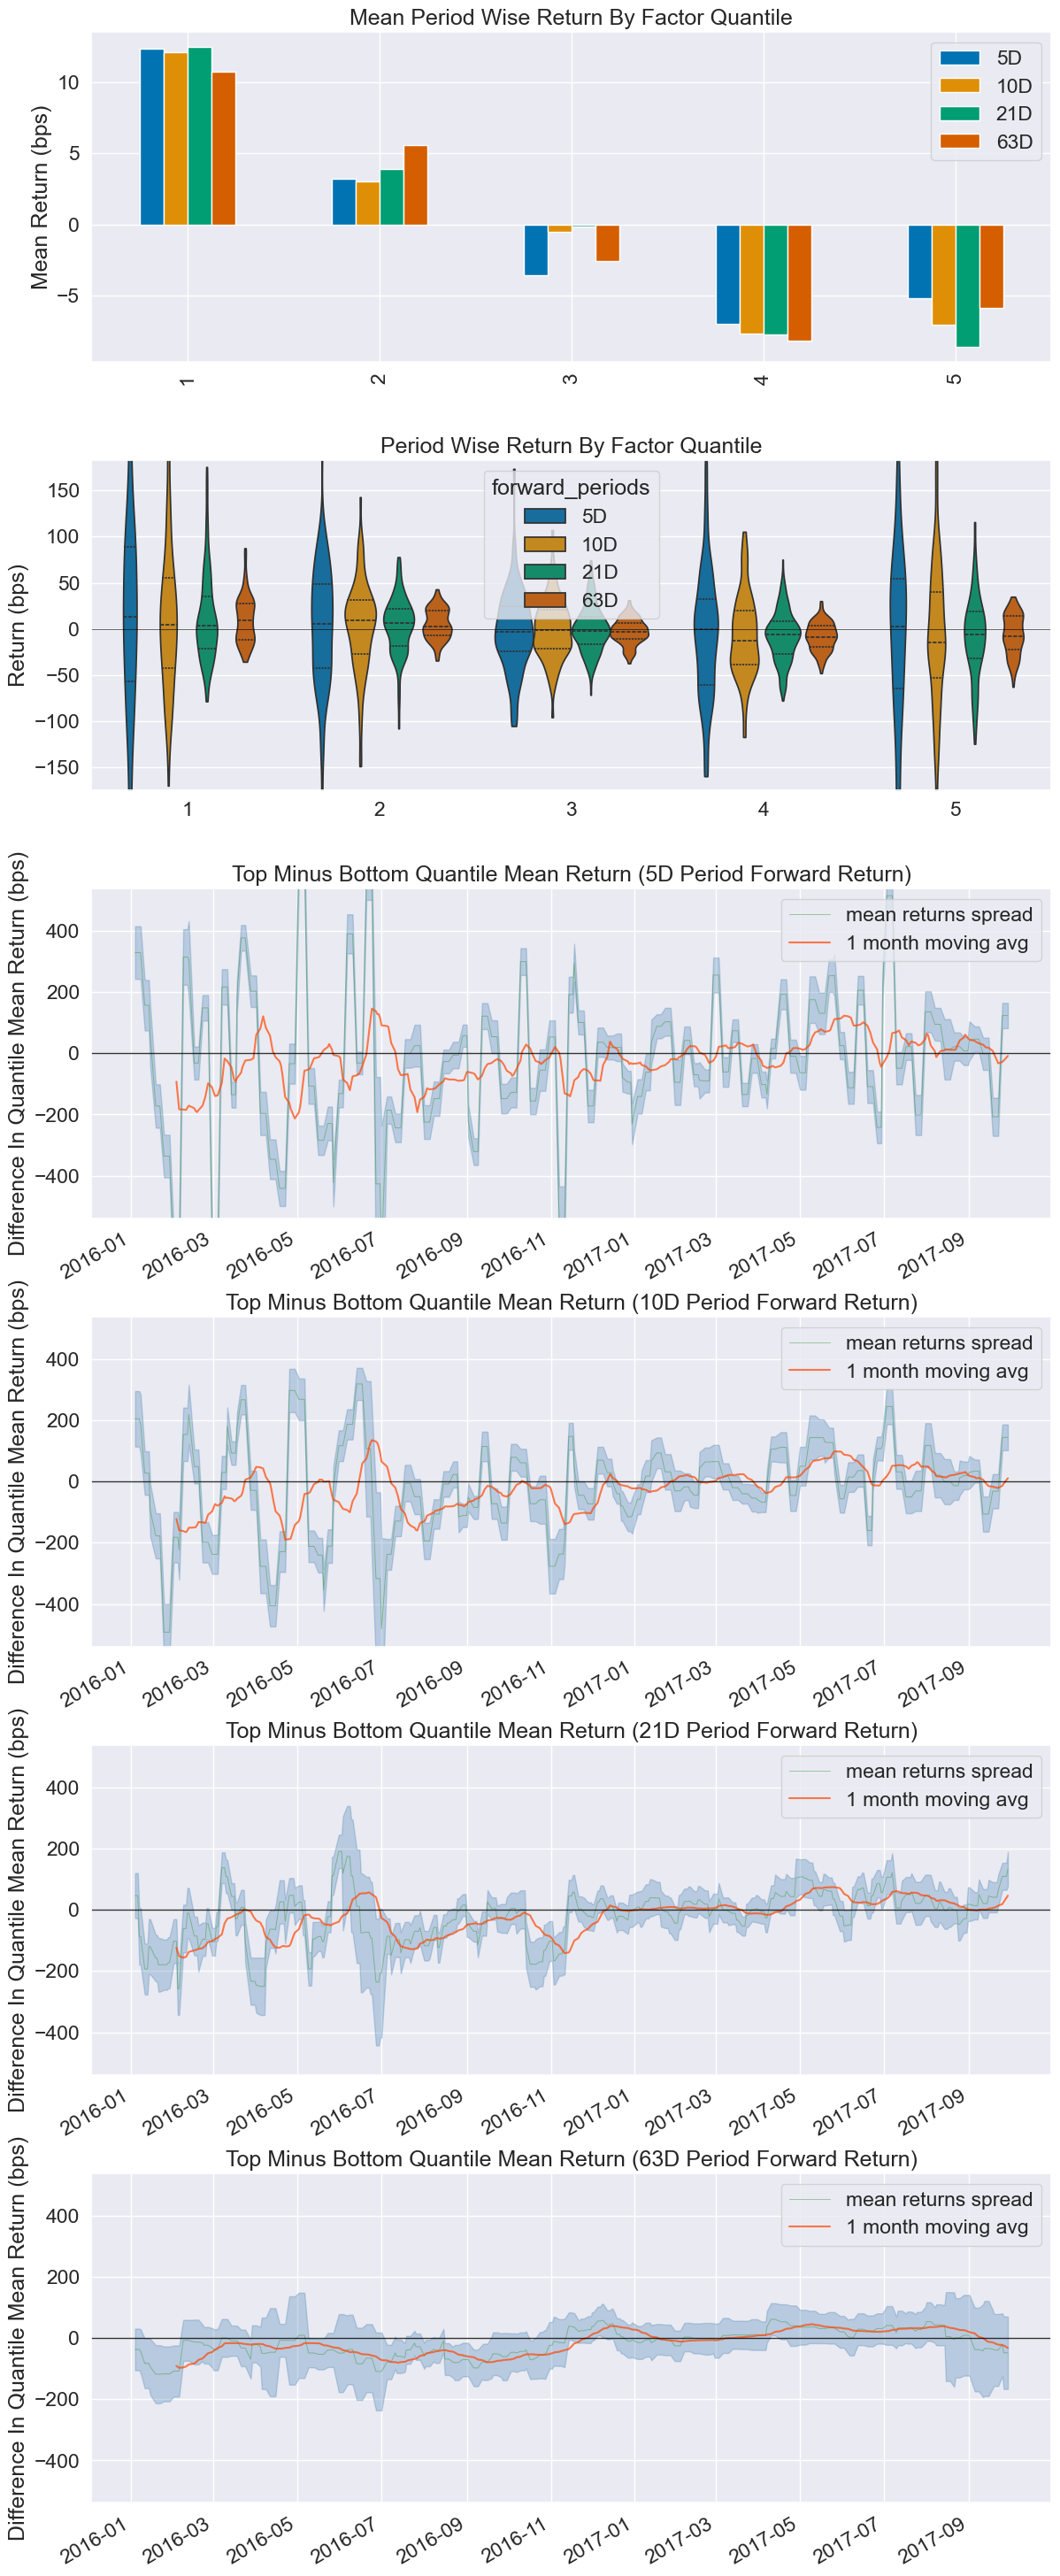

Information Analysis


5D    10D    21D    63D
IC Mean          -0.007 -0.014 -0.025 -0.031
IC Std.           0.213  0.202  0.167  0.148
Risk-Adjusted IC -0.033 -0.069 -0.153 -0.212
t-stat(IC)       -0.691 -1.451 -3.203 -4.457
p-value(IC)       0.490  0.147  0.001  0.000
IC Skew           0.423  0.373  0.353 -0.047
IC Kurtosis       0.276 -0.213  0.420 -1.058

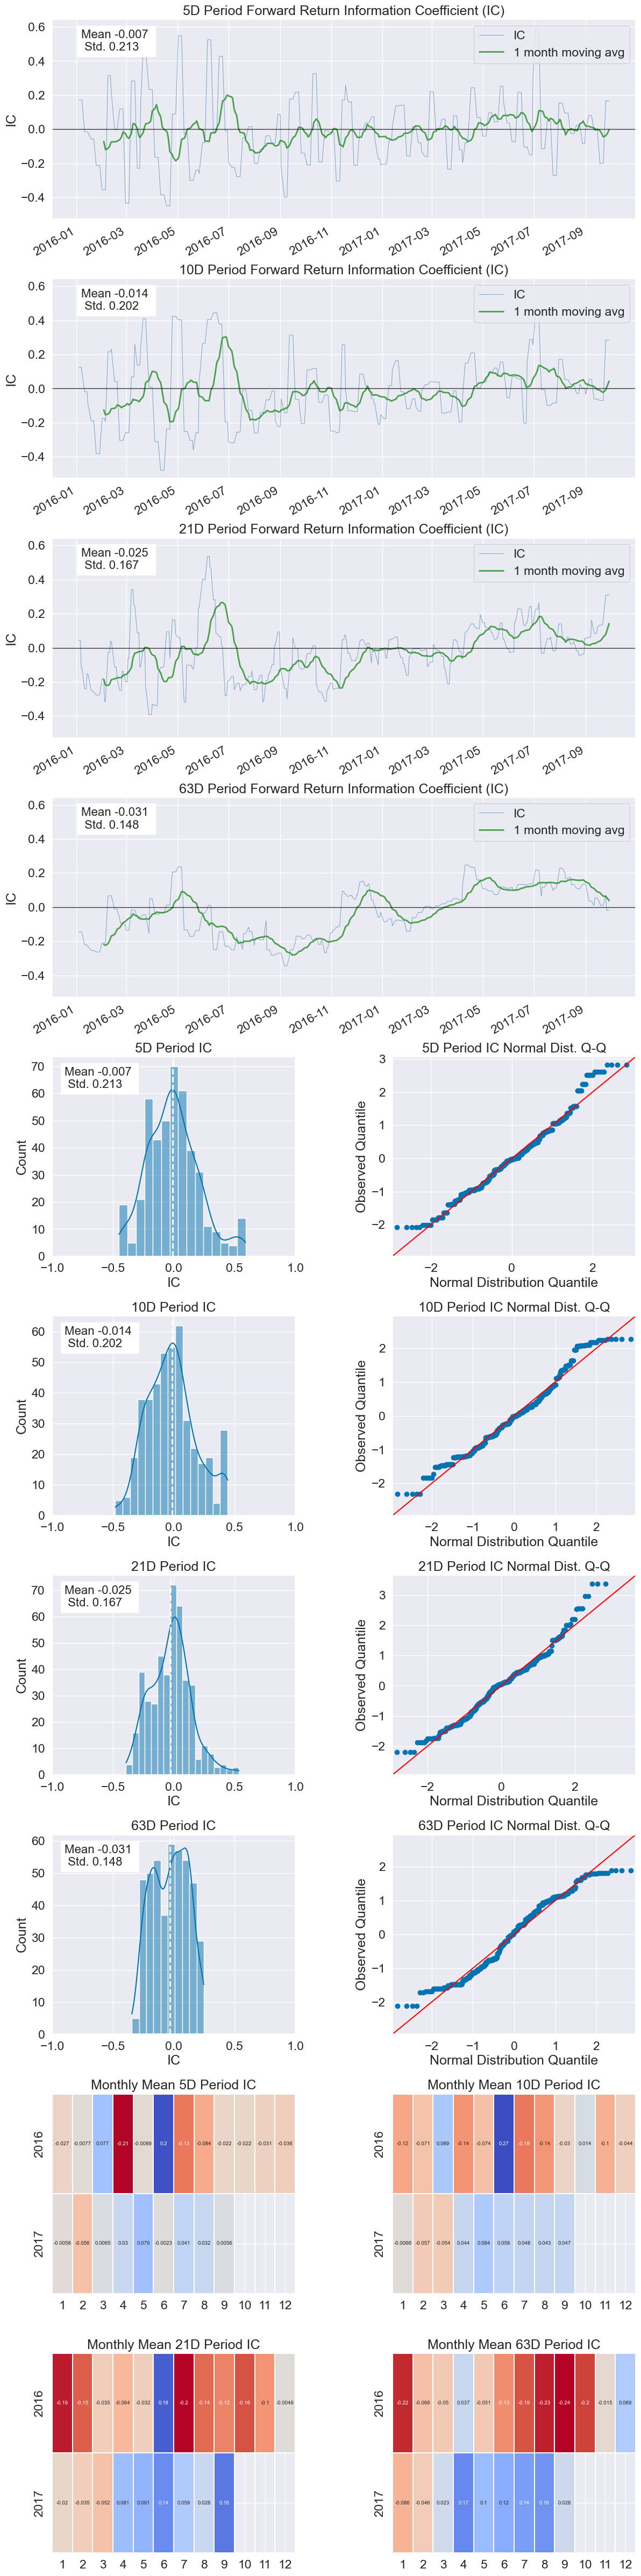

Turnover Analysis


5D    10D    21D    63D
Quantile 1 Mean Turnover   0.221  0.321  0.469  0.597
Quantile 2 Mean Turnover   0.407  0.536  0.664  0.756
Quantile 3 Mean Turnover   0.446  0.580  0.698  0.771
Quantile 4 Mean Turnover   0.403  0.528  0.652  0.732
Quantile 5 Mean Turnover   0.205  0.295  0.423  0.560

5D    10D    21D    63D
Mean Factor Rank Autocorrelation  0.929  0.863  0.732  0.544

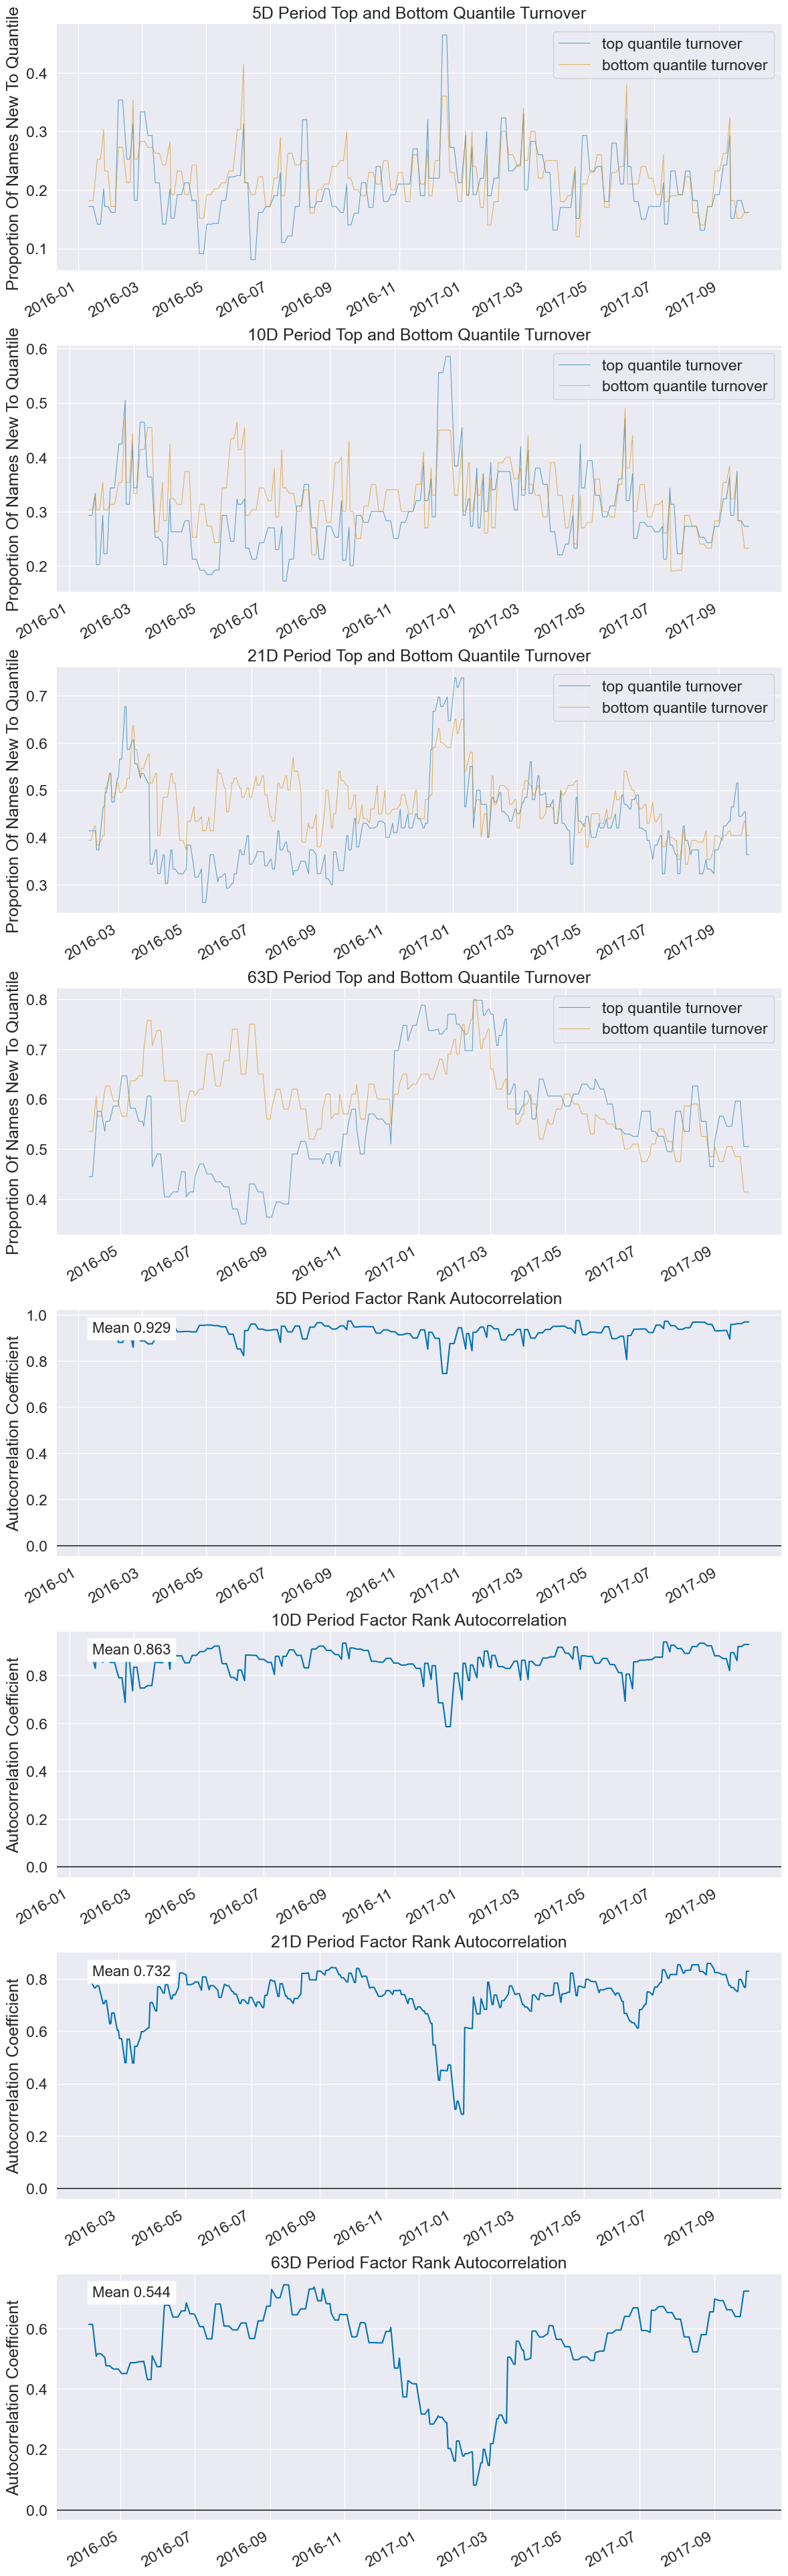

In [40]:
create_full_tear_sheet(alphalens_data)